## Adding Necessary Libraries

In [1]:
import nltk
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import ngrams
nltk.download('omw-1.4')
from itertools import chain
from datetime import datetime
from nltk import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import get_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import torch

import tensorflow as tf
!pip install transformers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig

SEEDER = 7
%matplotlib inline
random.seed(SEEDER)
tf.random.set_seed(SEEDER)
sns.set_palette('twilight')
plt.figure(figsize = (20,15))
warnings.filterwarnings('ignore')
sns.set(style = "whitegrid",font_scale = 1.2)

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


<Figure size 1440x1080 with 0 Axes>

## Data Loading

In [2]:
real_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

### Real news

In [3]:
df_rows, df_cols = real_df.shape
print(f"Number of records:\t{df_rows}\nNumber of attributes:\t{df_cols}")

Number of records:	21417
Number of attributes:	4


In [4]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


### Fake news

In [6]:
df_rows, df_cols = fake_df.shape
print(f"Number of records:\t{df_rows}\nNumber of attributes:\t{df_cols}")

Number of records:	23481
Number of attributes:	4


In [7]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


### Combine both categories

In [5]:
real_df['target'] = 1 # True
fake_df['target'] = 0 # False
df = pd.concat([real_df,fake_df])

df_rows, df_cols = df.shape
print(f"Number of records:\t{df_rows}\nNumber of attributes:\t{df_cols}")

Number of records:	44898
Number of attributes:	5


## Exploratory Data Analysis (EDA) & Preprocessing

In [10]:
df.isna().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

We may delete duplicated rows as there are no use of them:

In [6]:
print(f"The number of duplicated rows: {len(df)-len(df.drop_duplicates())}")
df = df.drop_duplicates()

The number of duplicated rows: 209


### `Target` column

In [12]:
df.groupby('target').count()['text'].reset_index().sort_values(by='text',ascending=False)

,target,text
0,0,23478
1,1,21211


[[Text(0, 0, 'fake'), Text(1, 0, 'real')]]

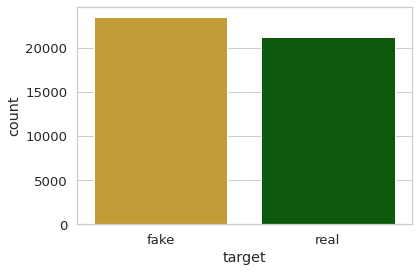

In [13]:
_ = sns.countplot(df['target'], palette=['goldenrod','darkgreen'])
_.set(xticklabels=['fake', 'real'])
# df['target'].value_counts().plot(autopct='%.2f%%', kind='pie', ylabel = "").set_title('News category')

### `Subject` column

In [7]:
df['subject'] = df['subject'].astype('category')
df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'Government News'),
 Text(1, 0, 'Middle-east'),
 Text(2, 0, 'News'),
 Text(3, 0, 'US_News'),
 Text(4, 0, 'left-news'),
 Text(5, 0, 'politics'),
 Text(6, 0, 'worldnews')]

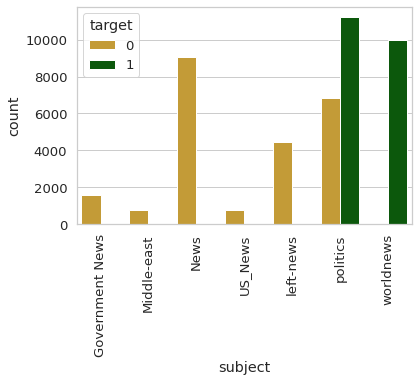

In [8]:
df['subject'] = df['subject'].replace({"politicsNews":"politics"})


# df['subject'].value_counts().plot(autopct='%.2f%%', kind='pie', ylabel = "").set_title('News category')
_ = sns.countplot(x = "subject", hue = "target" , data = df, palette=['goldenrod','darkgreen'])
_.set_xticklabels(_.get_xticklabels(),rotation=90)

### `Date` column

In [16]:
df['date'].nunique()

2397

Converting dates to the right format (year-month-day)...

In [7]:
df['new date'] = pd.to_datetime(df['date'].str.strip(), infer_datetime_format=True, errors='coerce')
df['new date'] = df['new date'].fillna(pd.to_datetime(df[df['new date'].isna() == True]['date'], infer_datetime_format=True, errors='coerce'))

In [18]:
df['new date'].nunique()

1010

Due to the different formats and blank spaces removing we reduced the number of unique dates.

In [45]:
df.isna().sum()

title        0
text         0
subject      0
date         0
target       0
new date    10
dtype: int64

As we may notice a few dates were not converted... Let's check them:

In [20]:
df[df['new date'].isna() == True]

,title,text,subject,date,target,new date
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0,NaT
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,NaT
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,0,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,NaT


These rows are invalid, so we may delete them:

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'News distribution in time')

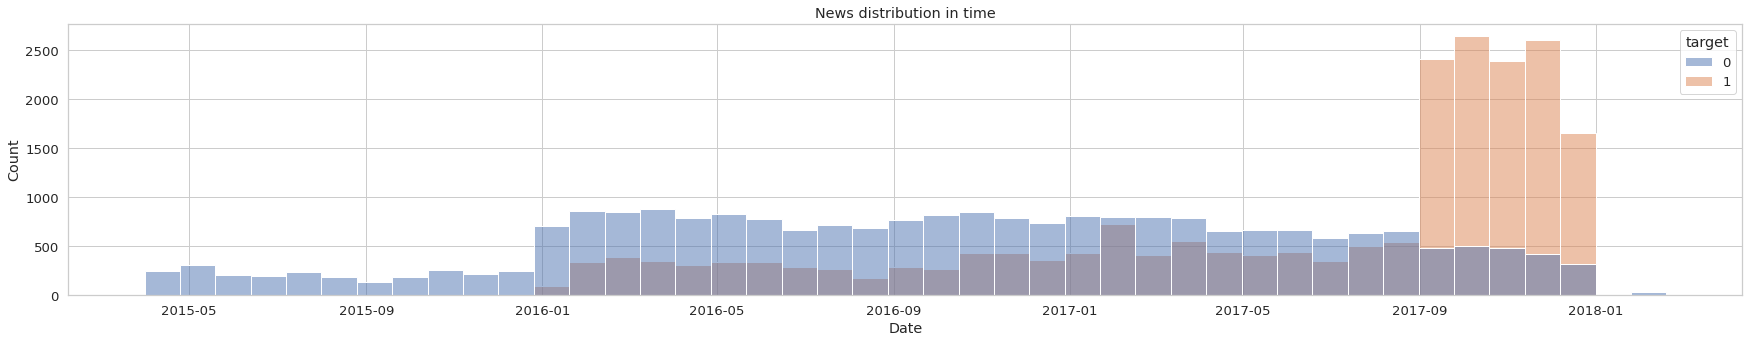

In [22]:
plt.figure(figsize = (30,5))
sns.histplot(data=df, x="new date", hue="target");
plt.xlabel('Date'), plt.ylabel('Count'); plt.title('News distribution in time')

I decided to convert our single date column to the separate ones, so we may use them in machine learning (if it will be necessary).

In [9]:
df["year"] = df["new date"].apply(lambda x: x.strftime("%Y"))
df["month"] = df["new date"].apply(lambda x: x.strftime("%m"))
df["day"] = df["new date"].apply(lambda x: x.strftime("%d"))

df = df.astype({'year': 'int64', 'month': 'int64', 'day': 'int64'})

I also used *sin* and *cos* encoding to mark cyclic data (months and days).

In [10]:
def encode(df, column, max_value):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column]/max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column]/max_value)
    return df

df = encode(df, "month", 12)
df = encode(df, "day", 31)

### `Title` and `Text` columns

First of all I decided to delete stop words (unnecessary words without any important information).

In [11]:
stop_words = stopwords.words('english')

df['clean title'] = df['title'].str.lower().str.split().apply(lambda x: [word for word in x if word not in stop_words])
df['clean text'] = df['text'].str.lower().str.split().apply(lambda x: [word for word in x if word not in stop_words])

Text(0.5, 1.0, 'Fake news')

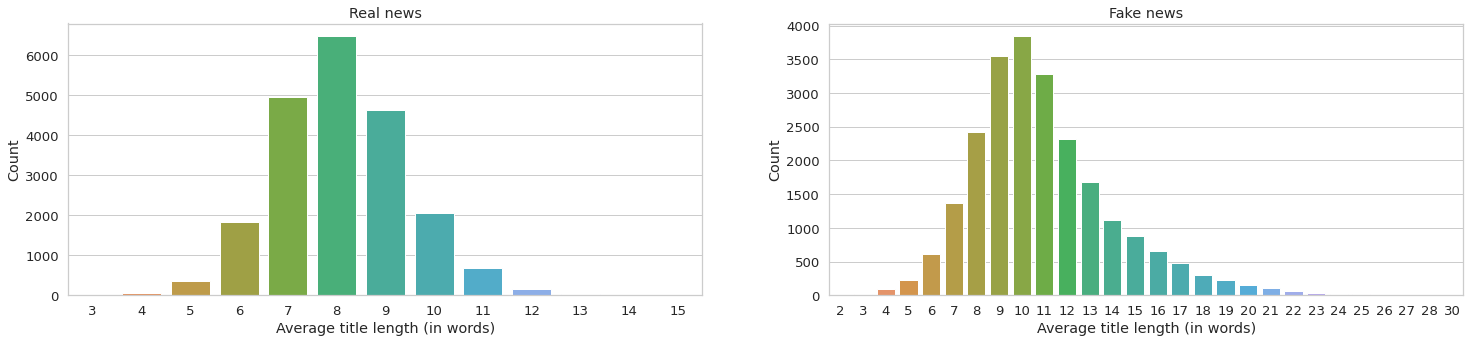

In [26]:
t_1 = df[df['target'] == 1]['clean title'].map(lambda x: len(x))
t_0 = df[df['target'] == 0]['clean title'].map(lambda x: len(x))

plt.subplots(1,2,figsize=(25,5))

plt.subplot(1,2,1); sns.countplot(t_1); 
plt.xlabel('Average title length (in words)'), plt.ylabel('Count'); plt.title('Real news')

plt.subplot(1,2,2); sns.countplot(t_0); 
plt.xlabel('Average title length (in words)'), plt.ylabel('Count'); plt.title('Fake news')

Word cloud for the real news:

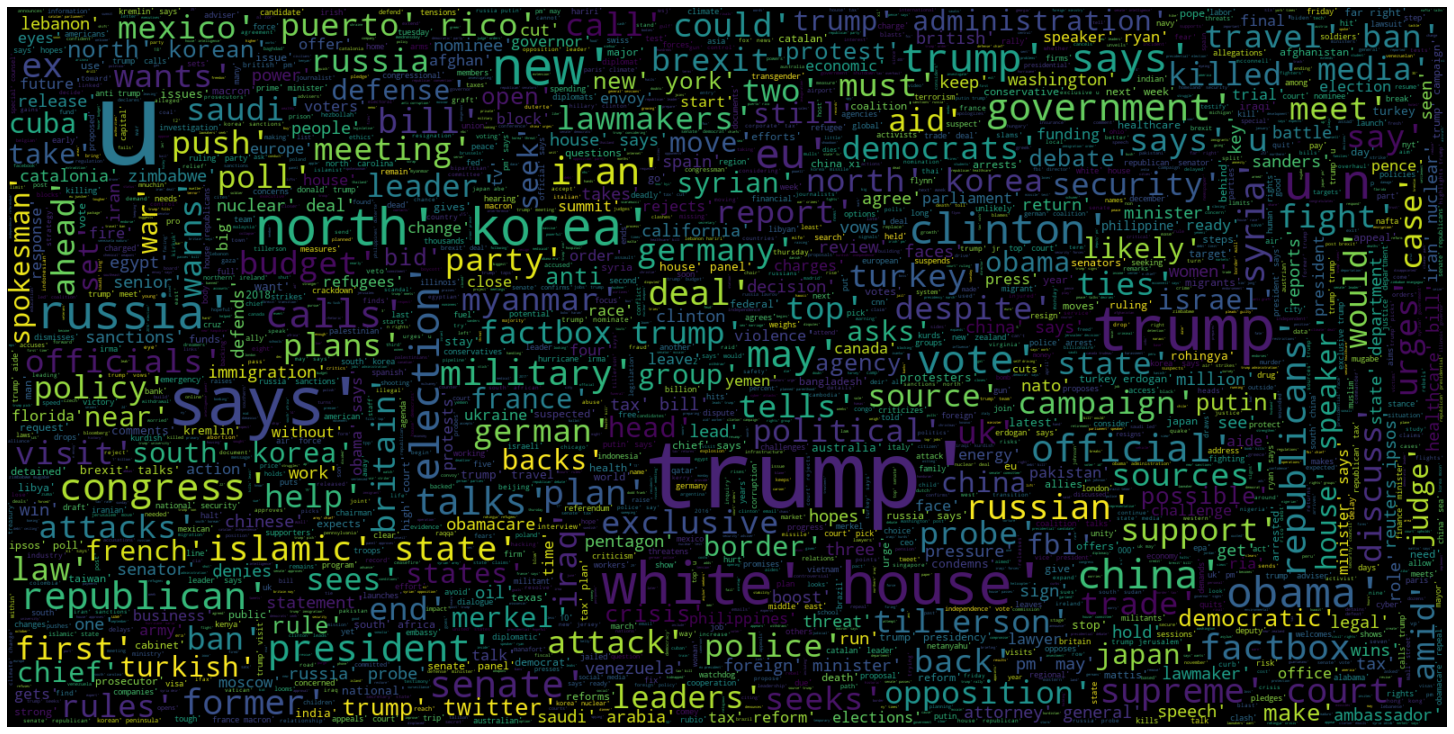

In [27]:
_ = WordCloud(width=1600, height=800,max_words = 2000, stopwords = stop_words, random_state = SEEDER, max_font_size=130).generate(" ".join([str(word) for word in df[df['target'] == 1]['clean title']]))
plt.figure(figsize = (20,15))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(_, interpolation = 'bilinear')

Word cloud for the fake news:

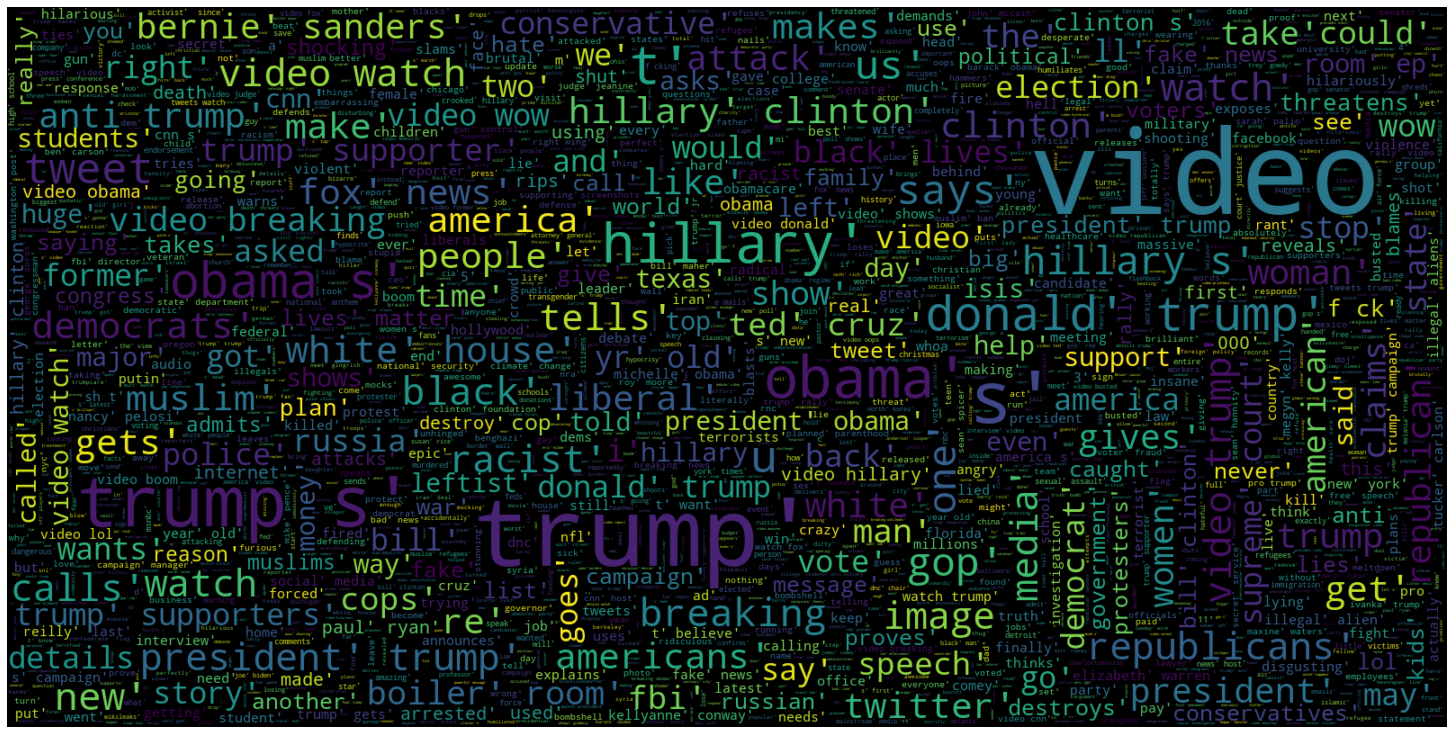

In [28]:
_ = WordCloud(width=1600, height=800,max_words = 2000, stopwords = stop_words, random_state = SEEDER, max_font_size=130).generate(" ".join([str(word) for word in df[df['target'] == 0]['clean title']]))
plt.figure(figsize = (20,15))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(_, interpolation = 'bilinear')

Text(0.5, 1.0, 'Fake news')

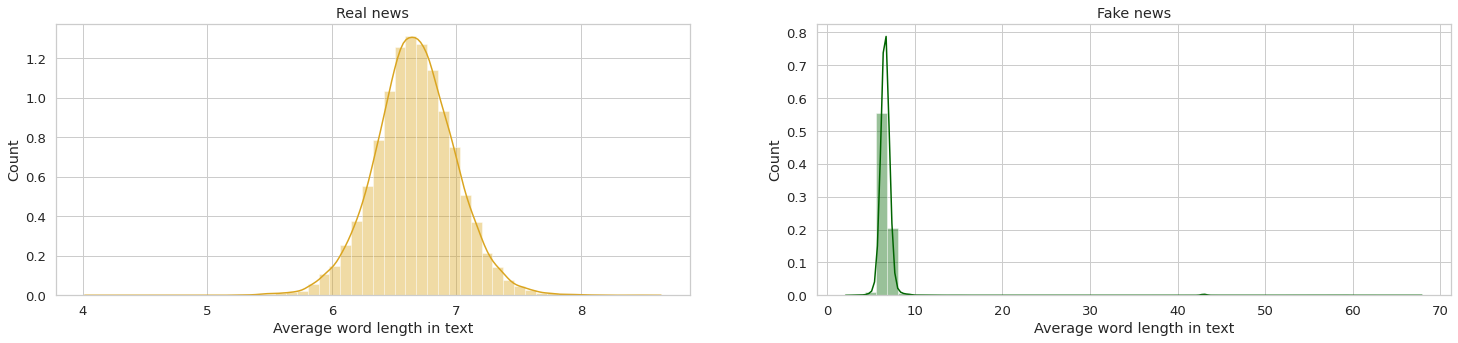

In [29]:
t_1 = df[df['target'] == 1]['clean text'].map(lambda x: [len(w) for w in x])
t_0 = df[df['target'] == 0]['clean text'].map(lambda x: [len(w) for w in x])

plt.subplots(1,2,figsize=(25,5))

plt.subplot(1,2,1); sns.distplot(t_1.map(lambda x: np.mean(x)),color='goldenrod');
plt.xlabel('Average word length in text'), plt.ylabel('Count'); plt.title('Real news')

plt.subplot(1,2,2); sns.distplot(t_0.map(lambda x: np.mean(x)), color='darkgreen');
plt.xlabel('Average word length in text'), plt.ylabel('Count'); plt.title('Fake news')

### Content combining and cleaning

In [12]:
df['whole news'] = df['clean title'].apply(lambda x: " ".join([str(word) for word in x])) + ' ' + df['clean text'].apply(lambda x: " ".join([str(word) for word in x]))

df['whole news'] = df['whole news'].str.lower()
df['whole news'] = df['whole news'].replace("n\'t",' not', regex=True)
df['whole news'] = df['whole news'].replace("\'m'",' am', regex=True)
df['whole news'] = df['whole news'].replace("won\'t",' will not', regex=True)
df['whole news'] = df['whole news'].replace("\'s",'', regex=True)
df['whole news'] = df['whole news'].replace("\'ll",' will', regex=True)
df['whole news'] = df['whole news'].replace("\'ve",' have', regex=True)
df['whole news'] = df['whole news'].replace("\'re",' are', regex=True)
df['whole news'] = df['whole news'].replace("\'d",' would', regex=True)
df['whole news'] = df['whole news'].replace("[^\w\s]",'', regex=True)
df['whole news'] = df['whole news'].replace("\[.*?\]",'', regex=True)
df['whole news'] = df['whole news'].replace("\n",' ', regex=True)
df['whole news'] = df['whole news'].replace("\t",' ', regex=True)
df['whole news'] = df['whole news'].replace("https?://\S+",'', regex=True)

I decided not to use lemmantization to save some relationships between words, but it is possible to carry out the experiment with the use of this technique.

In [31]:
# lemmatizer = WordNetLemmatizer()
# df['whole news'] = df['whole news'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

Text(0.5, 1.0, 'Fake news')

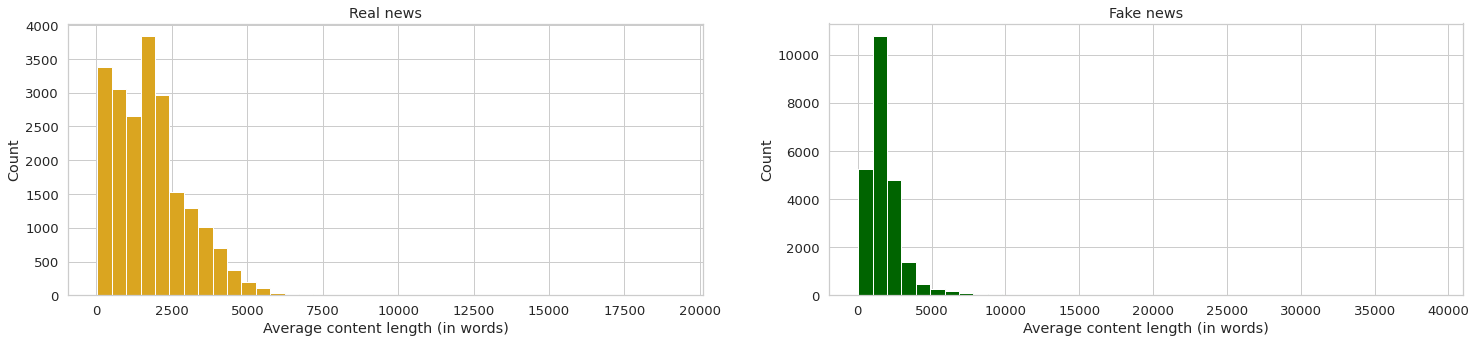

In [32]:
t_1 = df[df['target'] == 1]['whole news'].map(lambda x: len(x))
t_0 = df[df['target'] == 0]['whole news'].map(lambda x: len(x))

plt.subplots(1,2,figsize=(25,5))

plt.subplot(1,2,1); plt.hist(t_1, bins=40, color='goldenrod'); 
plt.xlabel('Average content length (in words)'), plt.ylabel('Count'); plt.title('Real news')

plt.subplot(1,2,2); plt.hist(t_0, bins=40, color='darkgreen');
plt.xlabel('Average content length (in words)'), plt.ylabel('Count'); plt.title('Fake news')

### Common content in both categories

In [33]:
clean_content = df['whole news'].str.lower().str.split().apply(lambda x: [word for word in x if word not in stop_words])
content = list(chain(*clean_content))
content_words = pd.DataFrame(data=Counter(content), index=['count'])
common_words = content_words.T.sort_values(by=['count'], ascending=False).reset_index()
common_words.head(10)

,index,count
0,said,129056
1,trump,128326
2,us,67715
3,would,55149
4,president,52339
5,people,41452
6,one,36091
7,new,32527
8,state,32116
9,also,31010


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'said'),
  Text(1, 0, 'trump'),
  Text(2, 0, 'us'),
  Text(3, 0, 'would'),
  Text(4, 0, 'president'),
  Text(5, 0, 'people'),
  Text(6, 0, 'one'),
  Text(7, 0, 'new'),
  Text(8, 0, 'state'),
  Text(9, 0, 'also'),
  Text(10, 0, 'house'),
  Text(11, 0, 'reuters'),
  Text(12, 0, 'donald'),
  Text(13, 0, 'clinton'),
  Text(14, 0, 'obama'),
  Text(15, 0, 'states'),
  Text(16, 0, 'government'),
  Text(17, 0, 'republican'),
  Text(18, 0, 'could'),
  Text(19, 0, 'white'),
  Text(20, 0, 'united'),
  Text(21, 0, 'told'),
  Text(22, 0, 'like'),
  Text(23, 0, 'campaign'),
  Text(24, 0, 'news'),
  Text(25, 0, 'last'),
  Text(26, 0, 'election'),
  Text(27, 0, 'two'),
  Text(28, 0, 'time'),
  Text(29, 0, 'party')])

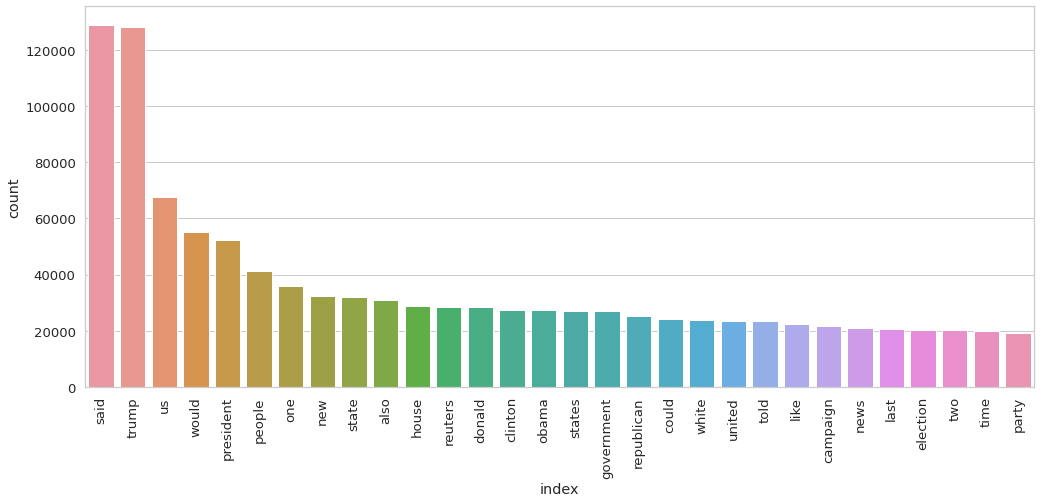

In [34]:
plt.figure(figsize=(17,7))
sns.barplot(x="index", y='count', data=common_words.head(30))
plt.xticks(rotation=90)

### N-gram for both categories

Text(0.5, 1.0, 'Fake news')

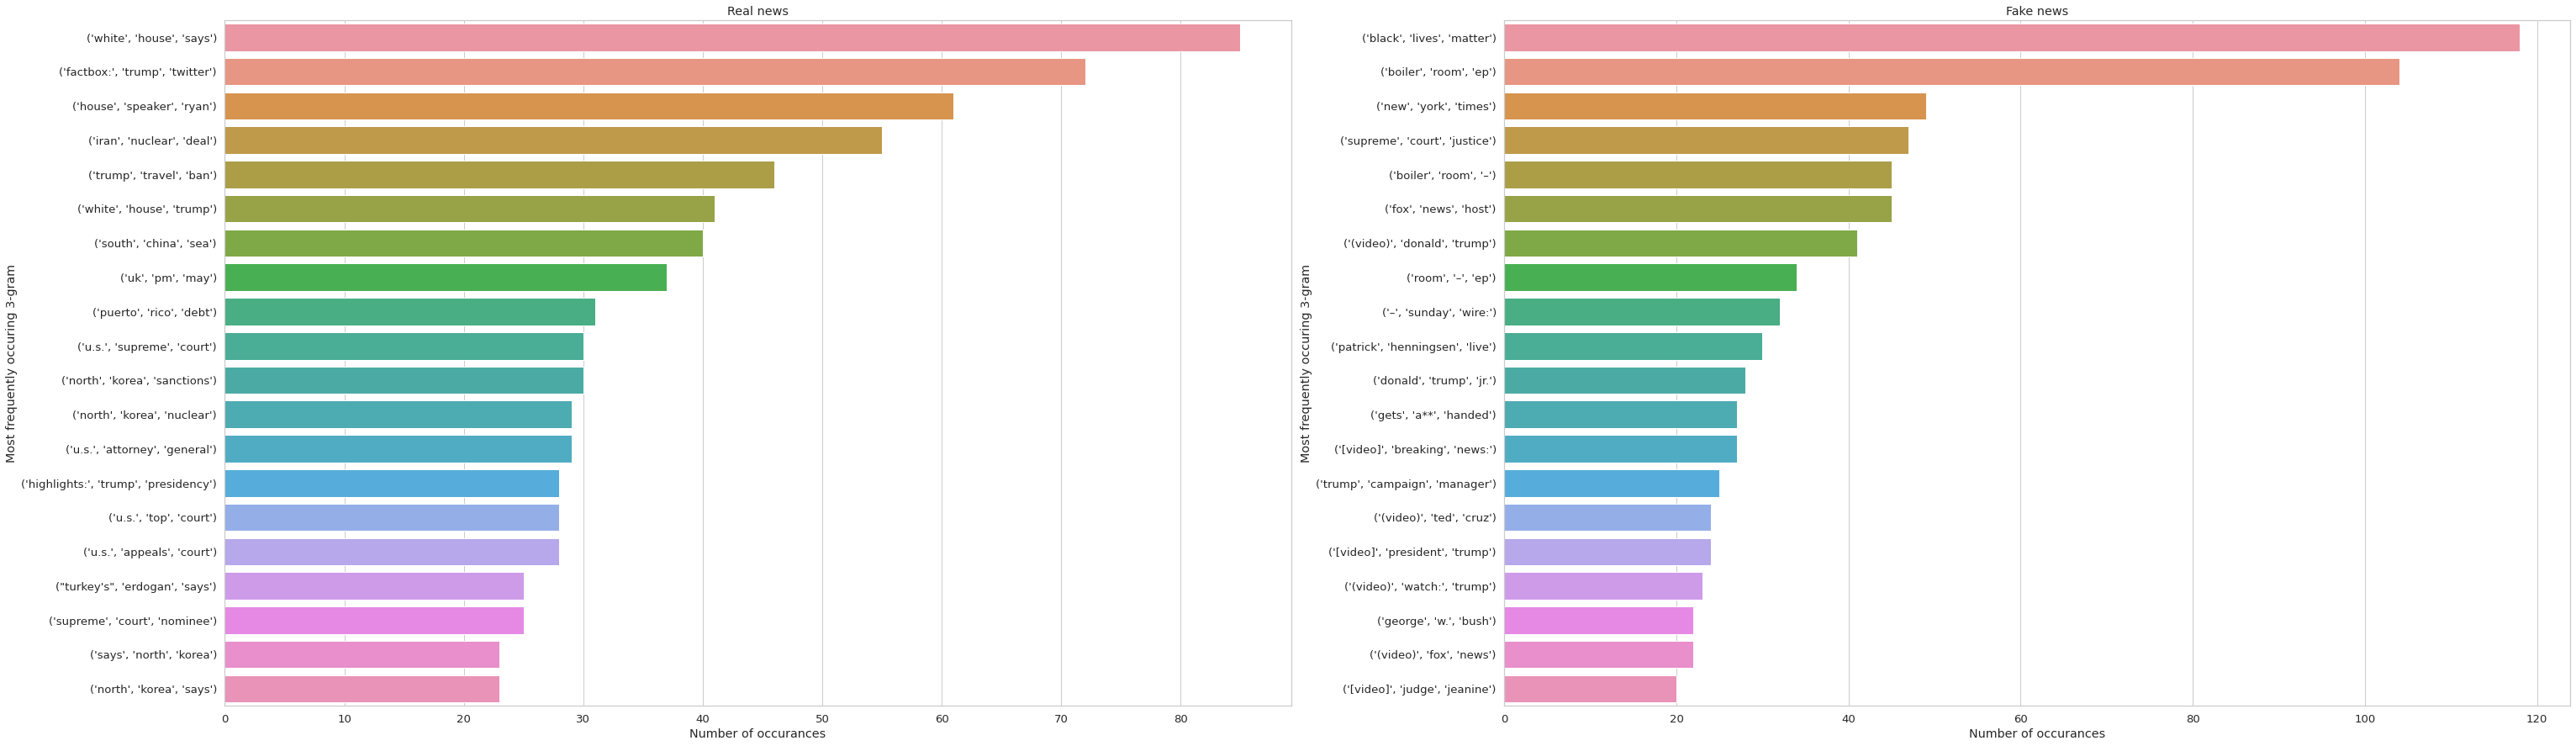

In [35]:
true_title = [' '.join(map(str, l)) for l in df[df['target'] == 1]['clean title']]
true_words_title = ' '.join(true_title).split(" ")
true_trigram = pd.DataFrame((pd.Series(nltk.ngrams(true_words_title, 3)).value_counts())[:20]).reset_index()

fake_title = [' '.join(map(str, l)) for l in df[df['target'] == 0]['clean title']]
fake_words_title = ' '.join(fake_title).split(" ")
fake_trigram = pd.DataFrame((pd.Series(nltk.ngrams(fake_words_title, 3)).value_counts())[:20]).reset_index()

plt.subplots(1,2,figsize=(50,15))

plt.subplot(1,2,1); sns.barplot(x=0,y='index', data=true_trigram, orient = "h");
plt.xlabel('Number of occurances'), plt.ylabel('Most frequently occuring 3-gram'); plt.title('Real news')

plt.subplot(1,2,2); sns.barplot(x=0,y='index', data=fake_trigram, orient = "h");
plt.xlabel('Number of occurances'), plt.ylabel('Most frequently occuring 3-gram'); plt.title('Fake news')

## Data Splitting

In [13]:
def split_data(x, y):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4, random_state = SEEDER)
    test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=0.5, random_state = SEEDER)

    print(">> Predictors <<")
    print(f'Train: {train_x.shape}\nValidation: {val_x.shape}\nTest: {test_x.shape}')
    print("\n>> Target <<")
    print(f'Train: {train_y.shape}\nValidation: {val_y.shape}\nTest: {test_y.shape}')
    
    return train_x, test_x, val_x, train_y, test_y, val_y

## Classification

### Logistic Regression, Random Forest & Naive Bayes Classifier

In [39]:
def plot_confusion_matrix(matrixes):
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    for index, (name, matrix_labels) in enumerate(matrixes.items()):
        m = ConfusionMatrixDisplay(confusion_matrix=matrix_labels[0], display_labels=matrix_labels[1])
        m.plot(ax=axes[index%3])
        axes[index%3].set(title='Confusion matrix for '+ name)
        axes[index%3].grid(False)

    plt.show()

In [40]:
def classification_pipeline(p_data_train, p_data_test, t_data_train, t_data_test):
    classificator_names = ["Logistic Regression", "Naive Bayes", "Random Forest"]

    classificator_functions = [LogisticRegression(random_state=SEEDER), GaussianNB(), RandomForestClassifier(random_state=SEEDER)]

    classificator_parameters = [{'C': [1, 5, 10], 'max_iter': [100, 300]}, 
                                {'priors': [[1 - np.mean(t_data_train), np.mean(t_data_train)]]}, 
                                {'n_estimators': [100, 200], 'max_depth': [3, 5, 20], 'max_features': [1, 3, 5]}]

    # empty dataframe of metrics
    metrics = pd.DataFrame({'Classificator Name': pd.Series(dtype='str'),
                   'Best Score (%)': pd.Series(dtype='str'),
                   'Accuracy (%)': pd.Series(dtype='float'),
                   'Precision (%)': pd.Series(dtype='float'),
                   'Recall (%)': pd.Series(dtype='float'),
                   'F1-score (%)': pd.Series(dtype='float'),
                   'Best Hyperparameters': pd.Series(dtype='str')})

    # empty dictionary of matrixes
    matrixes = {}

    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # execute for each classificator
    for index in range(len(classificator_names)):
        name = classificator_names[index]
        function = classificator_functions[index]
        parameters = classificator_parameters[index]

        # perform gridsearch and fit the model
        gscv = GridSearchCV(function, parameters) # scoring=get_scorer('roc_auc'), 
        result = gscv.fit(p_data_train, t_data_train)

        # make some predictions
        t_pred = result.predict(p_data_test)

        # count basic metrics about classificator performance
        best_score = np.round(gscv.best_score_ * 100, decimals=3)
        accuracy = np.round(accuracy_score(t_data_test, t_pred) * 100, decimals=3)
        precision = np.round(precision_score(t_data_test, t_pred) * 100, decimals=3)
        recall = np.round(recall_score(t_data_test, t_pred) * 100, decimals=3)
        f1 = np.round(f1_score(t_data_test, t_pred) * 100, decimals=3)

        m = {'Classificator Name': name, 'Best Score (%)': best_score, 
            'Best Hyperparameters': result.best_params_, 'Accuracy (%)': accuracy,
            'Precision (%)': precision, 'Recall (%)': recall, 'F1-score (%)': f1}
        metrics = metrics.append(m, ignore_index = True)
        
        # add the confusion matrix of the classificator
        matrix = confusion_matrix(t_data_test, t_pred, labels=result.classes_, normalize="all")
        matrixes[name] = (matrix, result.classes_)

        # ROC curve
        fpr, tpr, _ = roc_curve(t_data_test, t_pred)
        roc_auc = auc(fpr, tpr)
        curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
        curve.plot(ax=axes[0], label=f"AUC = {roc_auc:0.3f}, " + name)

        # Precision - Recall curve
        p, r, _ = precision_recall_curve(t_data_test, t_pred)
        avg_p = average_precision_score(t_data_test, t_pred)
        curve = PrecisionRecallDisplay(precision=p, recall=r, average_precision=avg_p, estimator_name=name)
        curve.plot(ax=axes[1], label=f"P = {avg_p:0.3f}, " + name)

    axes[0].set(title='ROC curve of models', xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[1].set(title='Precision-Recall curve', xlabel='Precision', ylabel='Recall')
    axes[0].legend(loc='lower right')
    axes[1].legend()

    plt.show()

    return metrics.set_index('Classificator Name'), matrixes

In [41]:
data_x = df["whole news"].sample(n = 3000) 
data_y = df["target"].sample(n = 3000)

train_x, test_x, val_x, train_y, test_y, val_y = split_data(data_x, data_y)

vectorization = TfidfVectorizer()

x_train = vectorization.fit_transform(train_x.copy())
x_test = vectorization.transform(test_x.copy())

print('\n>> Text vectorization ended sucessfully.')

>> Predictors <<
Train: (1800,)
Validation: (600,)
Test: (600,)

>> Target <<
Train: (1800,)
Validation: (600,)
Test: (600,)

>> Text vectorization ended sucessfully.


Evaluation of the performance...

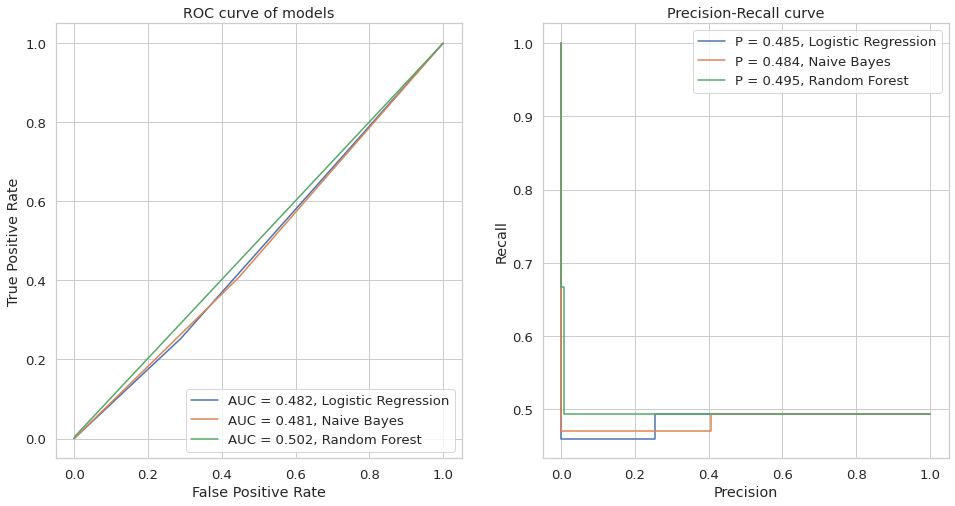

In [42]:
metrics, matrixes = classification_pipeline(x_train.toarray(), x_test.toarray(), train_y.copy(), test_y.copy())

In [43]:
metrics

,Best Score (%),Accuracy (%),Precision (%),Recall (%),F1-score (%),Best Hyperparameters
Classificator Name,,,,,,
Logistic Regression,50.056,48.500,46.012,25.338,32.680,"{'C': 1, 'max_iter': 100}"
Naive Bayes,49.500,48.167,47.059,40.541,43.557,"{'priors': [0.5388888888888889, 0.461111111111..."
Random Forest,54.000,50.833,66.667,0.676,1.338,"{'max_depth': 20, 'max_features': 5, 'n_estima..."


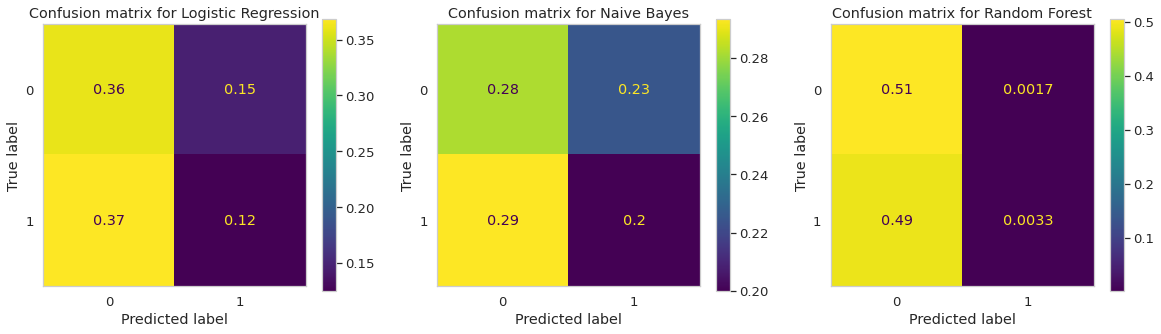

In [44]:
plot_confusion_matrix(matrixes)

### Long-Short Term Memory (LSTM)

In [69]:
wandb.login()
wandb.init(project="news_classification", entity="hrytsyna")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


GFLOPS,0.00083


In [70]:
epochs = 10
save_checkpoint = True

wandb.config = {"epochs": epochs, "save_checkpoint": save_checkpoint, '_wandb_kernel': 'neuracort'}

Let's divide our text into separate sequences...

In [71]:
data_x = df["whole news"]
data_y = df["target"]

train_x, test_x, val_x, train_y, test_y, val_y = split_data(data_x, data_y)
max_len = train_x.map(lambda x: len(x.split())).max()

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_x)

t_train = tokenizer.texts_to_sequences(train_x)
t_test = tokenizer.texts_to_sequences(test_x)

x_train = pad_sequences(t_train, maxlen=300)
x_test = pad_sequences(t_test, maxlen=300)

print('\n>> Text tokanization ended sucessfully.')

>> Predictors <<
Train: (26807,)
Validation: (8936,)
Test: (8936,)

>> Target <<
Train: (26807,)
Validation: (8936,)
Test: (8936,)

>> Text tokanization ended sucessfully.


**Model definition**

In [96]:
model = Sequential()
model.add(Embedding(10000, 32, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024, activation='relu'));  model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu'));   model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'));   model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'));   model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'));    model.add(Dropout(0.25))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4974, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 4974, 256)         164864    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 4974, 128)         164352    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

In [73]:
callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=4,verbose=1),
             ModelCheckpoint(filepath='weights', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1),
             WandbCallback()]

**Model training**

In [74]:
model.fit(x_train, train_y, batch_size=256, validation_data=(x_test, test_y), epochs=epochs, callbacks=callbacks)

2022-12-31 13:39:25.244209: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-12-31 13:39:25.244450: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-12-31 13:39:25.314163: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 901 nodes (744), 1247 edges (1060), time = 28.283ms.
  function_optimizer: function_optimizer did nothing. time = 0.647ms.

Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.


Epoch 1/10
105/105 [==============================] - 328s 3s/step - loss: 0.7040 - accuracy: 0.5721 - val_loss: 0.2873 - val_accuracy: 0.9133

Epoch 00001: val_accuracy improved from -inf to 0.91327, saving model to weights
Epoch 2/10
105/105 [==============================] - 320s 3s/step - loss: 0.1505 - accuracy: 0.9509 - val_loss: 0.0961 - val_accuracy: 0.9684

Epoch 00002: val_accuracy improved from 0.91327 to 0.96844, saving model to weights
Epoch 3/10
105/105 [==============================] - 325s 3s/step - loss: 0.0286 - accuracy: 0.9911 - val_loss: 0.0405 - val_accuracy: 0.9878

Epoch 00003: val_accuracy improved from 0.96844 to 0.98780, saving model to weights
Epoch 4/10
105/105 [==============================] - 328s 3s/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0558 - val_accuracy: 0.9890

Epoch 00004: val_accuracy improved from 0.98780 to 0.98903, saving model to weights
Epoch 5/10
105/105 [==============================] - 321s 3s/step - loss: 0.0063 - accurac

In [75]:
wandb.finish()

accuracy,▁▇██████
epoch,▁▂▃▄▅▆▇█
loss,█▂▁▁▁▁▁▁
val_accuracy,▁▆██▆▇▇█
val_loss,█▃▁▁▂▂▂▃
GFLOPS,0.00083
accuracy,0.99959
best_epoch,2
best_val_loss,0.04051
epoch,7
loss,0.00124


The best model performance was on the second epoch (till validation loss wasn't growing and our model wasn't pretrained). So, we will check some metrics for it

In [97]:
model.fit(x_train, train_y, batch_size=256, validation_data=(x_test, test_y), epochs=2)
predictions = model.predict(x_test)
preds = [np.argmax(i) for i in predictions]

Epoch 1/2
105/105 [==============================] - 330s 3s/step - loss: 0.6599 - accuracy: 0.6101 - val_loss: 0.2440 - val_accuracy: 0.9200
Epoch 2/2
105/105 [==============================] - 323s 3s/step - loss: 0.1415 - accuracy: 0.9486 - val_loss: 0.0685 - val_accuracy: 0.9774


,Accuracy (%),Precision (%),Recall (%),F1-score (%)
0,97.739,96.963,98.221,97.588


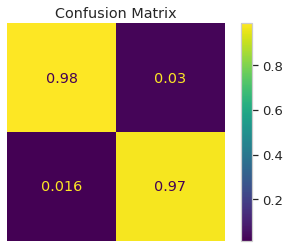

In [125]:
accuracy = np.round(accuracy_score(test_y, preds) * 100, decimals=3)
precision = np.round(precision_score(test_y, preds) * 100, decimals=3)
recall = np.round(recall_score(test_y, preds) * 100, decimals=3)
f1 = np.round(f1_score(test_y, preds) * 100, decimals=3)

m = {'Accuracy (%)': [accuracy], 'Precision (%)': [precision], 'Recall (%)': [recall], 'F1-score (%)': [f1]}
display(pd.DataFrame.from_dict(m))

# add the confusion matrix of the classificator
matrix = confusion_matrix(test_y, preds, labels = [0, 1], normalize="pred")
m = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = [0, 1])
m.plot()
plt.axis('off')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Bidirectional Encoder Representations from Transformers (BERT)

**Model definition**

This time we will use already pretrained Bert model and perform transfer learning...

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False)
model.config.num_labels = 2
optimizer = AdamW(model.parameters(), lr = 0.01)
epochs = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
wandb.login()
wandb.init(project="news_classification_2", entity="hrytsyna")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [23]:
wandb.config = {"learning_rate": 0.01, "epochs": epochs, "batch_size": 32, "save_checkpoint": True}

Let's divide our data into tokens and create binary labels (masks) for them...

In [27]:
df = df.sample(n = 1000)
input_ids = []
for n in df["whole news"].values:
    encoded_news = tokenizer.encode(n, add_special_tokens = True)
    input_ids.append(encoded_news)
    
input_ids = pad_sequences(input_ids, maxlen=256 , truncating="post", padding="post")   

attention_masks = []
for n in input_ids:
    mask = [int(token_id > 0) for token_id in n]
    attention_masks.append(mask)

In [28]:
train_x, val_x, train_y, val_y = train_test_split(input_ids, df["target"].values, test_size=0.2, random_state = SEEDER)
train_m, val_m, _, _ = train_test_split(attention_masks, df["target"].values, test_size=0.2, random_state = SEEDER)

train_x = torch.tensor(train_x); val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y); val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m); val_m = torch.tensor(val_m)

train_data = TensorDataset(train_x, train_m, train_y)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
val_data = TensorDataset(val_x, val_m, val_y)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=32)

**Training our model**

In [62]:
train_loss = []
val_loss = []

predictions = []
true_labels = []

for epoch in range(0, epochs):
    model.train()
    total_loss = 0 
    for step, batch in enumerate(train_dataloader):
        outputs = model(batch[0].to(device), token_type_ids=None, attention_mask=batch[1].to(device), labels=batch[2].to(device))

        loss = outputs[0]
        total_loss += loss.item()
        
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader) 
    train_loss.append(avg_train_loss)
    
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for step, batch in enumerate(train_dataloader):
            outputs = model(batch[0].to(device), token_type_ids=None, attention_mask=batch[1].to(device), labels=batch[2].to(device))

            loss = outputs[0]
            total_loss += loss.item()
            
            predictions.append(outputs[1].detach().cpu().numpy())
            true_labels.append(batch[2].to('cpu').numpy())

    avg_val_loss = total_loss / len(train_dataloader) 
    val_loss.append(avg_val_loss)
    
    print('EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs, avg_train_loss, avg_val_loss))
    
    wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss})

EPOCH 1/10 	 train loss 0.702 	 val loss 0.701
EPOCH 2/10 	 train loss 0.698 	 val loss 0.701
EPOCH 3/10 	 train loss 0.703 	 val loss 0.701
EPOCH 4/10 	 train loss 0.703 	 val loss 0.701
EPOCH 5/10 	 train loss 0.705 	 val loss 0.701
EPOCH 6/10 	 train loss 0.702 	 val loss 0.701
EPOCH 7/10 	 train loss 0.703 	 val loss 0.701
EPOCH 8/10 	 train loss 0.707 	 val loss 0.701
EPOCH 9/10 	 train loss 0.701 	 val loss 0.701
EPOCH 10/10 	 train loss 0.700 	 val loss 0.701


As we may see - both loss values are almost constant, so we will check some evaluation metrixes... 

In [30]:
wandb.finish()

train_loss,▃▁█▅▄▃▁▄▁▆
val_loss,▁▁▁▁▁▁▁▁▁▁
train_loss,0.70724
val_loss,0.70129


In [63]:
preds = np.concatenate(predictions, axis=0)
preds = np.argmax(preds, axis=1).flatten()
test_y = np.concatenate(true_labels, axis=0)

,Accuracy (%),Precision (%),Recall (%),F1-score (%)
0,51.625,51.625,100.0,68.096


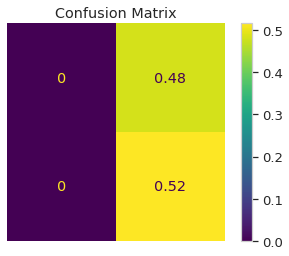

In [67]:
accuracy = np.round(accuracy_score(test_y, preds) * 100, decimals=3)
precision = np.round(precision_score(test_y, preds) * 100, decimals=3)
recall = np.round(recall_score(test_y, preds) * 100, decimals=3)
f1 = np.round(f1_score(test_y, preds) * 100, decimals=3)

m = {'Accuracy (%)': [accuracy], 'Precision (%)': [precision], 'Recall (%)': [recall], 'F1-score (%)': [f1]}
display(pd.DataFrame.from_dict(m))

# add the confusion matrix of the classificator
matrix = confusion_matrix(test_y, preds, labels = [0, 1], normalize="all")
m = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = [0, 1])
m.plot()
plt.axis('off')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()